# XPSWMM 1D Inlet 2D Capture Default Option

When a node is linked to the 2D using "Link Spill Crest to 2D", there a few ways to define how the flow exchanges between 1d/2d.
- using the inet capacity settings (1)
- using 2D inflow Capture (2)
- default

And I found the "default" option can be confusing, and here I will try to clarify it a little bit.


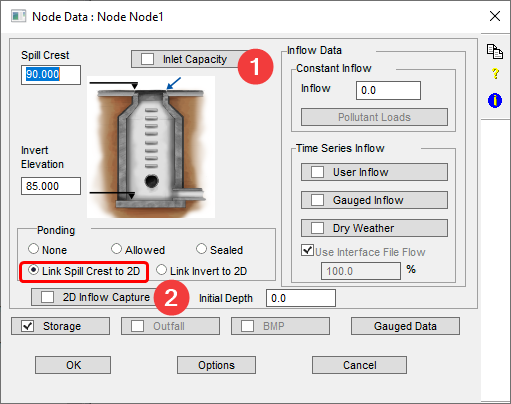

Accordign to the [help](https://help.innovyze.com/display/xps/2D+Job+Control+Settings#id-2DJobControlSettings-2DInflowCapture), 2D inflow capture is the preferred option and the "default" option is a pretty old method that shouldn't be used.

**As you can see, the 'pre-2009 method' is dependent on the 1D/2D sync time, if you half the time step, the flow rate will double. Not a great choice for 1d/2d flow exchange.**

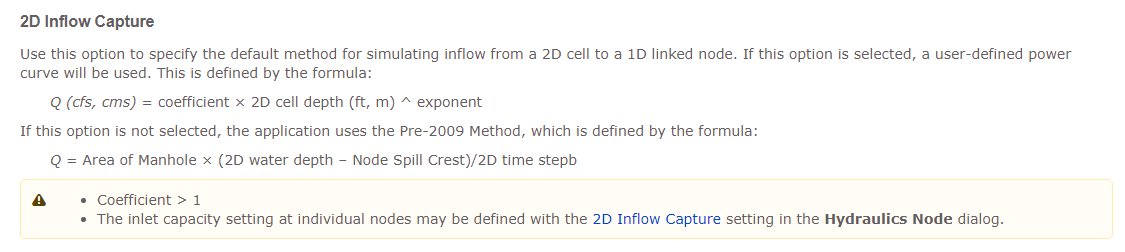

# Tests

All the models can be found on [github](https://github.com/mel-meng/xpswmm/tree/master/models/1d2d/data).

To get better idea how XPSWMM handles the "default" options in 2019.1.2, and I did a few tests and here is a quick summary of my findings.

* The defatul setting is not reliable. It looks like if I ever set the 2D flow capture option, even if I turn it off. The “default” will be using the 2D inflow capture instead.
* The default 2d inflow capture is Q=13.382*depth^0.5, even though I didn’t enter anything in the settings
* For a clean 2D model, when using the default setting, the 1d/2d sync time does impact the flow rate as shown in the help file.

The results are based on the figure below,
* All the dashed lines are manually calculated using the equation from the help file, and they match pretty well with the simulated results.
* Only the default_1sec_clean/default_2sec_clean showed the expected behavior for “default” settings, which is a clean model without ever setting 2D capture
* All other models show the same results using the default 2D flow capture, although I checked it off




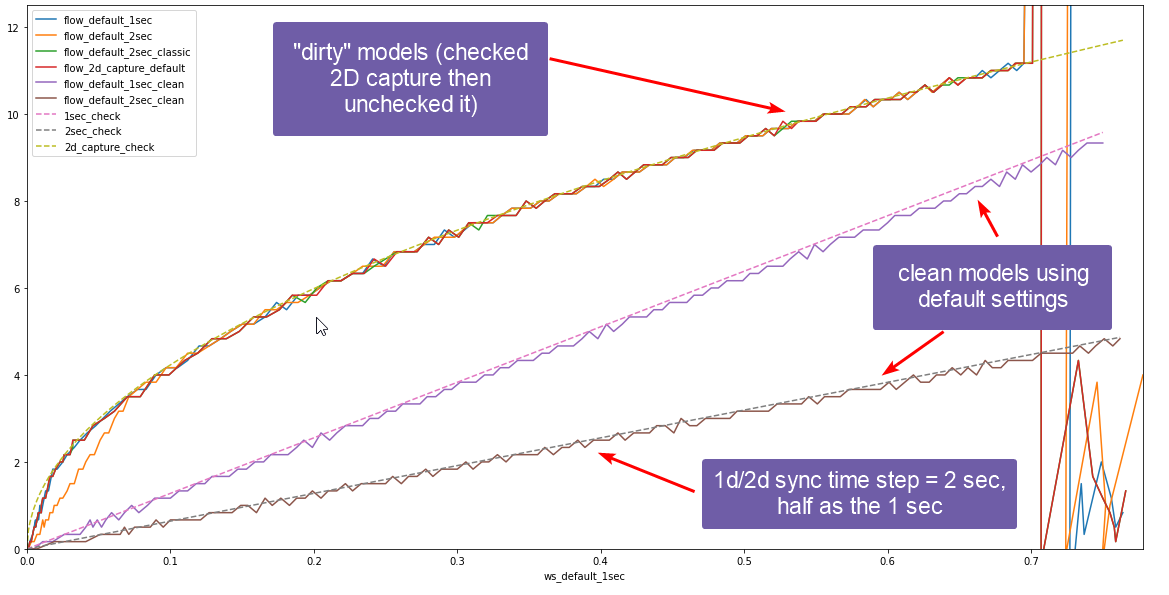

# Recommendations,

I will not use the “default” option for my 2D model, and I'll use the global 2D flow capture to ensure that the 2D inflow option is used. Then I'll change individual inlets for more fine tuning.



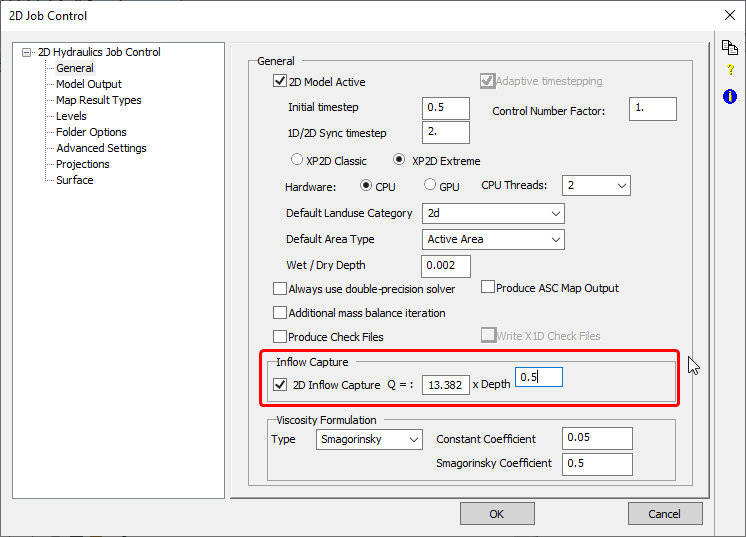

# Model

Here is how I setup the model and developed the curves. 

# 2D surface
I just need some water ponding on top of the inlet. It is not a good looking surface. A flat surface of 90ft is setup, then I added inflow at one end and a boundary at another end.

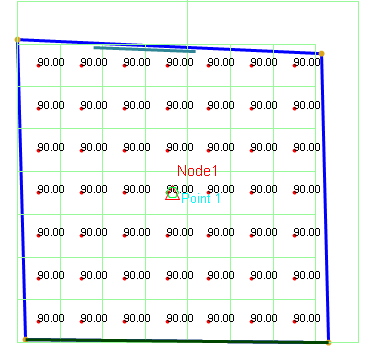

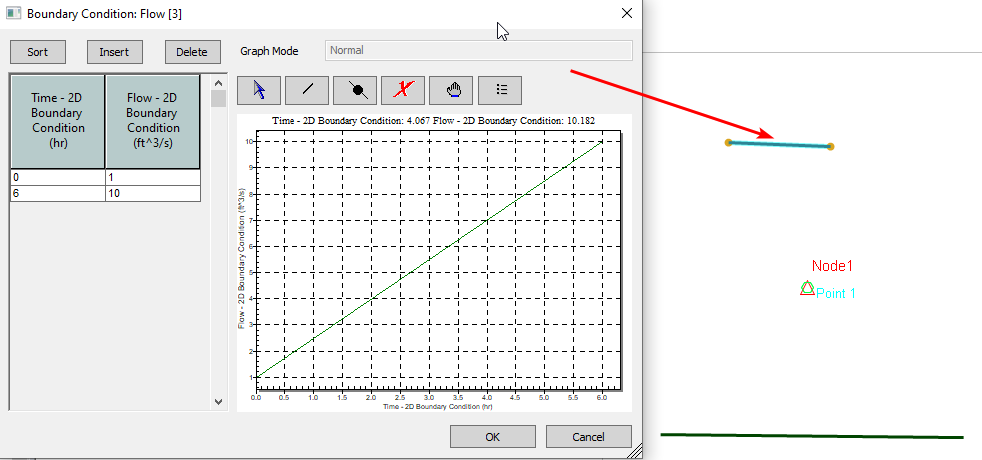

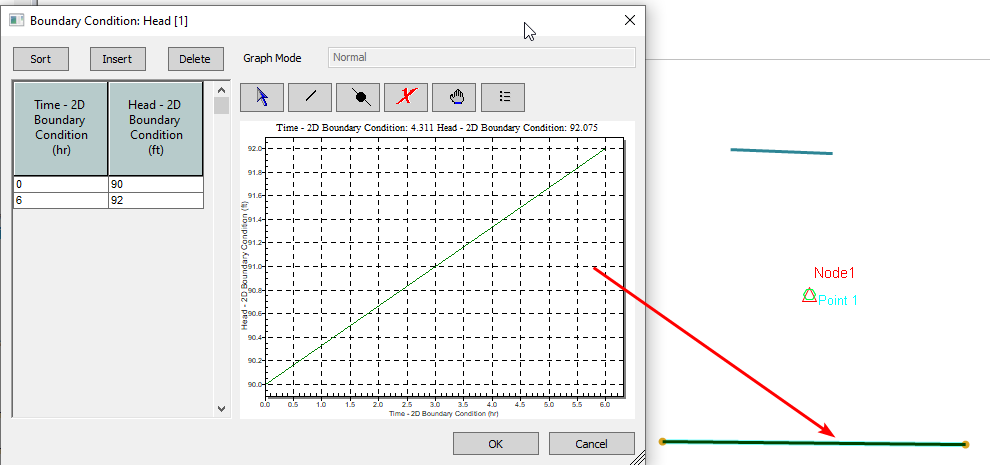

## Storage

There is no good way to get the inflow into a node without using an inlet. So my hack is to setup the node as storage with constact area, so that I can calculate inlet inflow from the stage.

I added a storage node with 
- fixed area of 10000 sf
- invert of 85ft
- link to the crest the same as the 2D 90ft

With this model (1d_inlet.xp), I can calculate the flows into the storage node using the stage changes.

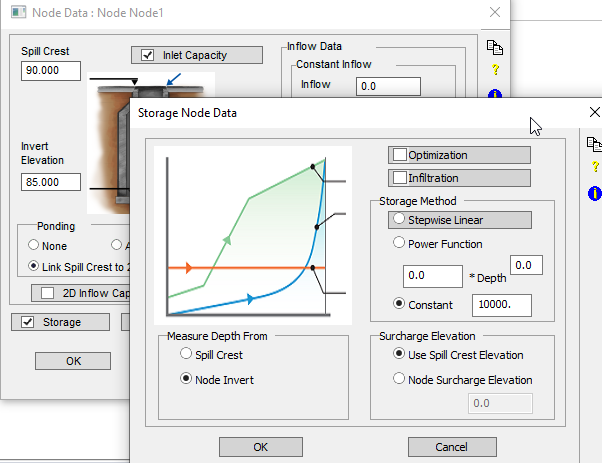

# Scenarios

All models are using the extreme engine and the same 1d/2d settings except,

- "dirty" models, I turned on the 2d flow capture and run the model, then checked it off
 - default_1sec: 1d/2d sync time step = 1 sec
 - default_2sec: 1d/2d sync time step = 2 sec
- compare models
 - default_2sec_classic: using the classic engine
 - 2d_capture_default: using the 2d inflow capture option
- a clean model
 - default_1sec_clean: 1d/2d sync time step = 1 sec
 - default_2sec_clean: 1d/2d sync time step = 2 sec


# Results

I exported the Stage and 2D water surface time series for the comparison to develop the relationship between Q and Depth.



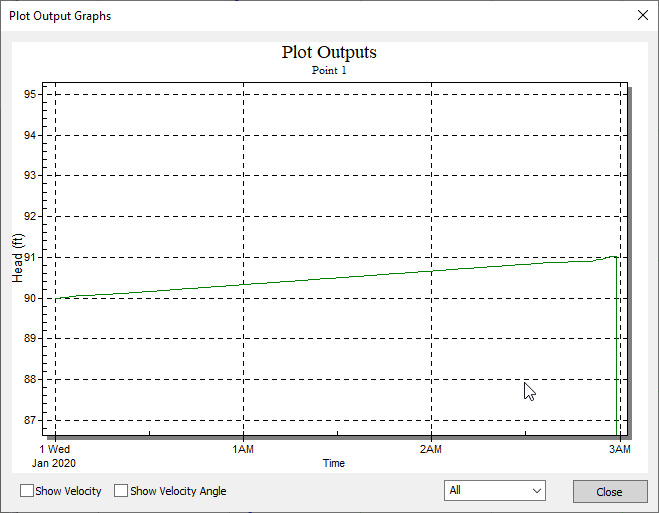

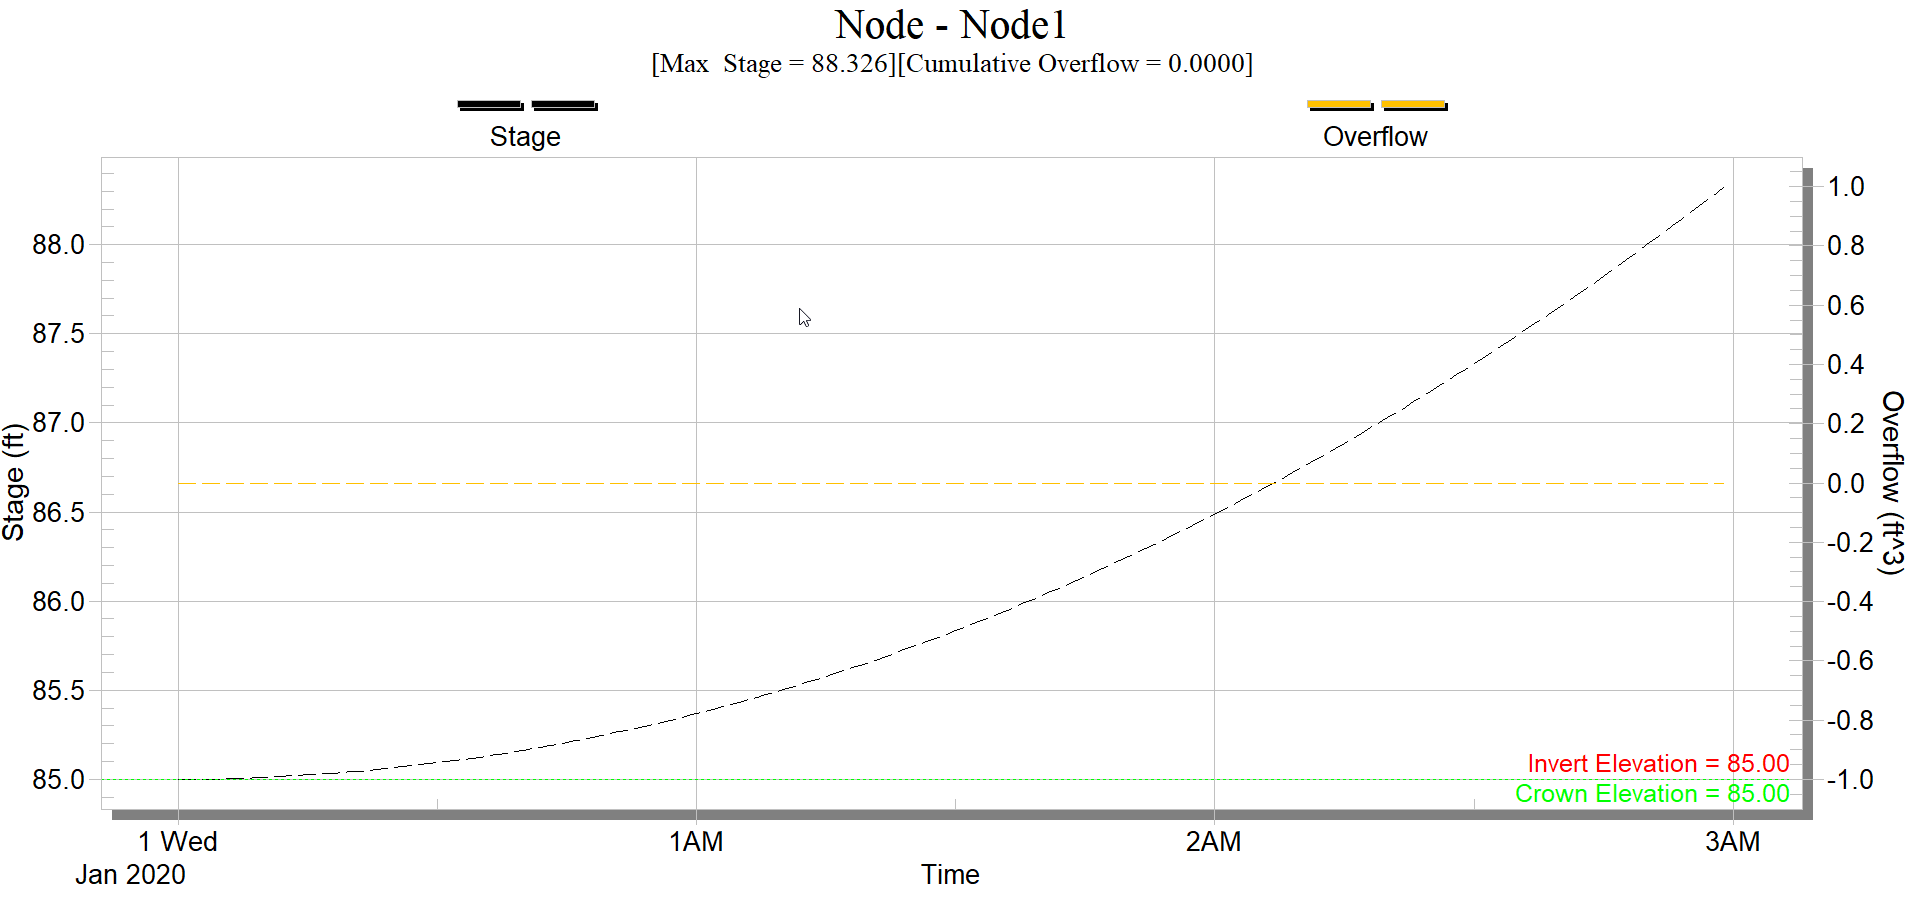

# Compare Results

I copy and pasted the results from XPSWMM to an excel file: default_inlet.xlsx. Then did some calculations to get,
* flow: Q = (stage@time step 2 - stage@time step 1)*area/time step
* Depth D= water head - node rim elevation


In [18]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [19]:
ws = r'C:\Users\Mel.Meng\Documents\GitHub\xpswmm\models\1d2d\data'

# for inlet modeled as storage flow = (stage@ts2- stage@ts1)*area/ts
area = 10000 # storage constant area in ft2
ts = 60.0 # time step in sec
rim = 90 # rim elevation in ft

excel_path = os.path.join(ws, 'default_inlet.xlsx')
df = pd.read_excel(excel_path)

for fld in df.columns:
    if 'ws_' in fld: # convert water surface as depth above rim
        df[fld] = df[fld] - rim
    if 'stage_' in fld: # calculate flow rates from stage
        sc = fld.replace('stage_', '')
        df['flow_%s' % sc] = df[fld].diff()*area/ts      

df = df[df['min'] < 140]

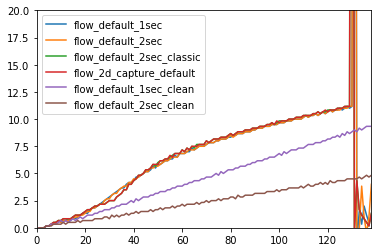

In [20]:
scenarios = ['default_1sec', 'default_2sec', 'default_2sec_classic', '2d_capture_default', 'default_1sec_clean', 'default_2sec_clean']
ax = df.loc[df['min']<140, ['flow_%s' % x for x in scenarios]].plot()
ax.set_ylim(0, 20)
plt.show()

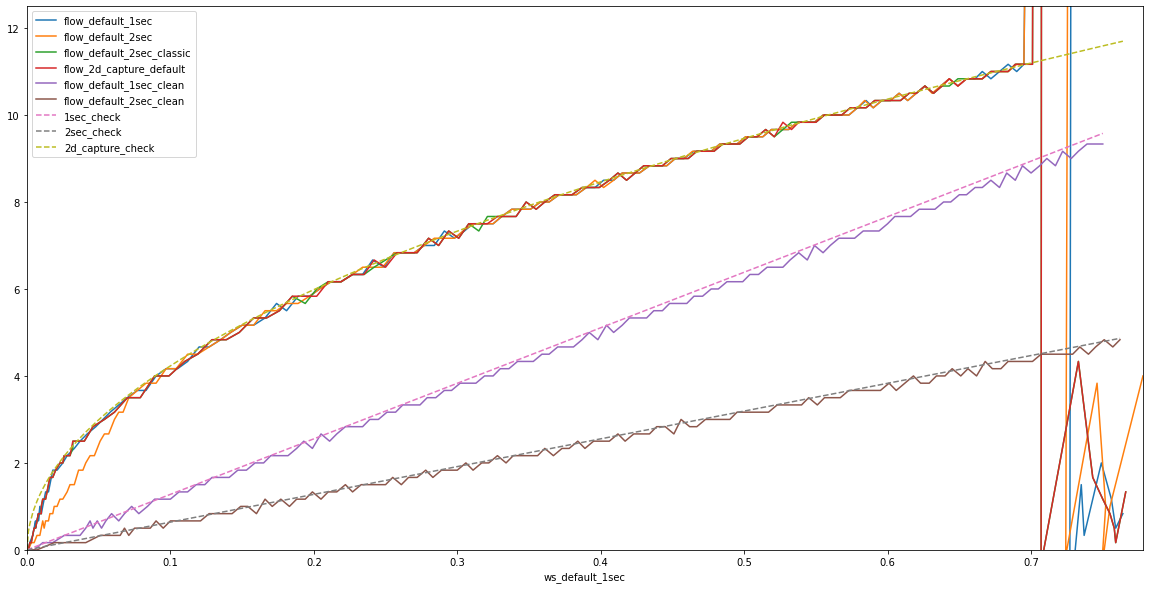

In [23]:
import numpy as np
ax = None
df['1sec_check'] = df['ws_default_1sec_clean']*12.77
df['2sec_check'] = df['ws_default_2sec_clean']*12.77/2.0
df['2d_capture_check'] = np.power(df['ws_default_1sec'], 0.5)*13.382

for sc in scenarios:
    if ax is None:
        ax = df.plot(x='ws_%s' % sc, y='flow_%s' % sc, figsize=(20, 10))
    else:
        df.plot(x='ws_%s' % sc, y='flow_%s' % sc, ax=ax)
df.plot(x='ws_default_1sec_clean', y='1sec_check', style='--', ax=ax)
df.plot(x='ws_default_2sec_clean', y='2sec_check', style='--', ax=ax)
df.plot(x='ws_default_1sec', y='2d_capture_check', style='--', ax=ax)
ax.set_ylim(0, 12.5)
plt.show()